## Create Initial states

In [1]:
import numpy as np
from pathlib import Path
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt

from src.models.normal import NormalDegradationModel as NModel
from src.models.particle_filter import ParticleFilterModel,ParticleFilterMLP
from src.models.system_rul import SystemRUL

In [2]:
data_name = "DS03"

device = "cpu"

experiment_dir = Path('experiments')/data_name
pf_dir = experiment_dir/'pf_perform_relu64x64'
states_dir = experiment_dir/'states'

## Import development data


In [3]:
hi_df = pd.read_csv(experiment_dir/'hidata_dev.csv')
del hi_df['hs']
units = hi_df['unit'].astype(int).unique().tolist()
units 

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle']]

performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in units}

## Prepare data

In [5]:
eval_data = {}
for name, perform_units in performs.items():
    eval_perform_data = {}
    for unit in units:
        t_data = time[unit]
        s_data = performs[name][unit]
        eval_perform_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32).to(device)
    eval_data[name]=eval_perform_data

## Load pf models

In [6]:
hidden_dims = [64,64]
activation = torch.nn.ReLU()

n_particles = 1800
multiply_scale = 0.01
start_idx = 5

In [7]:
pfs = {}
for name, perform_units in performs.items():
	perform_pfs = {}
	# load pf-network
	net = ParticleFilterMLP(state_dim=NModel.state_dim(), hidden_dims=hidden_dims,
                        activation=lambda : activation).to(device)
	ckpt = torch.load(pf_dir/name/'checkpoint.pt', map_location=device)
	net.load_state_dict(ckpt['model_state'])
	net = net.to(device).eval() 
	
	degmodels = []
	for unit, perform in perform_units.items():
		best_model = NModel()
		best_model.load_state_dict(
			torch.load(states_dir/ name /f'unit_{unit}'/ "best_model.pt", map_location=device)
		)
		best_model.to(device)
		degmodels.append(best_model)
  
	for eval_unit in units:
		train_degmodels = [model for i, model in enumerate(degmodels) if units[i] != eval_unit]
		perform_pfs[eval_unit] = ParticleFilterModel(base_models = train_degmodels,
                                            net = net,
                                            max_life=100,
                                            n_particles=n_particles,
        									multiply_scale=multiply_scale,
        									name=f'{name}_eval unit{eval_unit}').to(device)
	pfs[name] = perform_pfs

## Create System RULs

In [8]:
sys_ruls:dict[int,SystemRUL] = {}
for unit in units:
	pf_models = {name: pfs[name][unit] for name in perform_names}
	sys_ruls[unit] = SystemRUL(pf_models=pf_models)

In [9]:
sys_ruls

{1: <src.models.system_rul.SystemRUL at 0x1080e3a90>,
 2: <src.models.system_rul.SystemRUL at 0x1161cd150>,
 3: <src.models.system_rul.SystemRUL at 0x116445050>,
 4: <src.models.system_rul.SystemRUL at 0x116446010>,
 5: <src.models.system_rul.SystemRUL at 0x116444350>,
 6: <src.models.system_rul.SystemRUL at 0x116445990>,
 7: <src.models.system_rul.SystemRUL at 0x116445b90>,
 8: <src.models.system_rul.SystemRUL at 0x1162c7090>,
 9: <src.models.system_rul.SystemRUL at 0x116315390>}

## Load best model

In [10]:
# t = np.linspace(0.1, 100, 400)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
# s = np.linspace(0.0, 1.0, 300)
# trian_units = range(1,9)
# test_unit = 9
# pf_models: dict[str,ParticleFilterModel]= {}
# observations = {}
# for name, units_perform in performs_train.items():
#     models = []
#     obs_test = {}
#     for unit, perform in units_perform.items():
#         if unit in trian_units:
#             best_model = NModel()
#             best_model.load_state_dict(
# 				torch.load(states_dir /name/f'unit_{unit}'/ "best_model.pt", map_location=device)
# 			)
#             best_model.to(device)
#             best_model.eval()
#             models.append(best_model)
#         else:
#             obs_test[unit] = perform,time_train[unit]
            
#     observations[name]=obs_test
#     pf_models[name]=ParticleFilterModel(base_models=models,
#                         net=ParticleFilterMLP(state_dim=5,hidden_dims=[3, 16]),
#                         max_life = 100.0,
#                         multiply_scale=0.05,
#                         n_particles=1800,
#                         name = name).to(device)

# system_model = RULPredictor(pf_models=pf_models)

## Create plot

In [11]:
def create_plot(t_grid:np.ndarray,
                s_grid:np.ndarray,
                t_data_np:np.ndarray,
                s_data_np:dict[str,np.ndarray],
                step:int,
                uncertainty_level: float,
				sys_rul:SystemRUL,
				eol_time: float,
				test_unit:int,
):
    fig = plt.figure(figsize=(20, 9))
    gs = fig.add_gridspec(
        2, 3,
        width_ratios=[2.8, 2, 2],
        wspace=0.15,
        hspace=0.20,
    )
    
    ax_rul = fig.add_subplot(gs[:, 0])
    ax_pf = [
        fig.add_subplot(gs[0, 1]),
        fig.add_subplot(gs[0, 2]),
        fig.add_subplot(gs[1, 1]),
    ]
    
    fig.add_subplot(gs[1, 2]).axis("off")  # empty slot
        
    
    for ax, (name, pf) in zip(ax_pf,sys_rul.pf_models.items()):
        # distribution
        pf.mixture.plot_distribution(
            ax=ax,
            t=t_grid,
            s=s_grid,
            title=f"{name} | unit {test_unit} | step {step}",
            vmax=0.25,
            plot_mean=True,
        )
        
        # data
        pf.mixture.plot_observations(
            ax=ax,
            t_obs=t_data_np,
            s_obs=s_data_np[name],
            current_idx=step,
        )	
        
        # uncertainty interval
        device = next(pf.parameters()).device
        s0 = torch.zeros(1, dtype=torch.float32, device=device)
        lower, mean, upper = pf.mixture.uncertainty_interval(s=s0, level=uncertainty_level)
        pf.mixture._plot_uncertainty_interval(
            ax=ax,
            lower=lower.item(),
            mean=mean.item(),
            upper=upper.item(),
            ymax=1.0,
            label=f"{int(uncertainty_level * 100)}% uncertainty",
        )

    sys_rul.plot_rul(
        ax=ax_rul,
        eol_time=eol_time,
        y_max=100,
        title=f"System RUL – unit {test_unit}",
    )

    fig.canvas.draw()
    frame = np.asarray(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return frame

## System RUL

In [12]:
eval_unit = 9
uncertainty_level = 0.95

t_grid = np.linspace(0.1, 100, 80)  # Start from 0.1 instead of 0.0 (LogNormal support is t > 0)
s_grid = np.linspace(0.0, 1.0, 60)

In [13]:
frames = []


sys_rul = sys_ruls[eval_unit]
perfrom_names = sys_rul.pf_models.keys()
n_performs = len(sys_rul.pf_models)

sys_rul.reset_history()

data_s = {name: performs[name][eval_unit] for name in perfrom_names}
data_t = time[eval_unit]
for k, t_curr in enumerate(time[eval_unit]):
    sys_rul.observe(
        time=t_curr,
        observations={name: s[k] for name,s in data_s.items()}
    )
    sys_rul.step()

    sys_rul.record(t_curr)

    frame = create_plot(
        t_grid=t_grid,
        s_grid=s_grid,
        t_data_np=data_t,
		s_data_np=data_s,
        sys_rul=sys_rul,
        eol_time=time[eval_unit][-1],
        test_unit=eval_unit,
        step=k,
        uncertainty_level=uncertainty_level,
    )
  
    frames.append(frame)

## Save video

In [14]:
import imageio

video_path = "pf_full.mp4"

with imageio.get_writer(video_path, fps=8, macro_block_size=1) as writer:
    for frame in frames:
        writer.append_data(frame)

print(f"🎬 Video saved to {video_path}")

🎬 Video saved to pf_full.mp4


## Plot System RUL

NameError: name 'system_model' is not defined

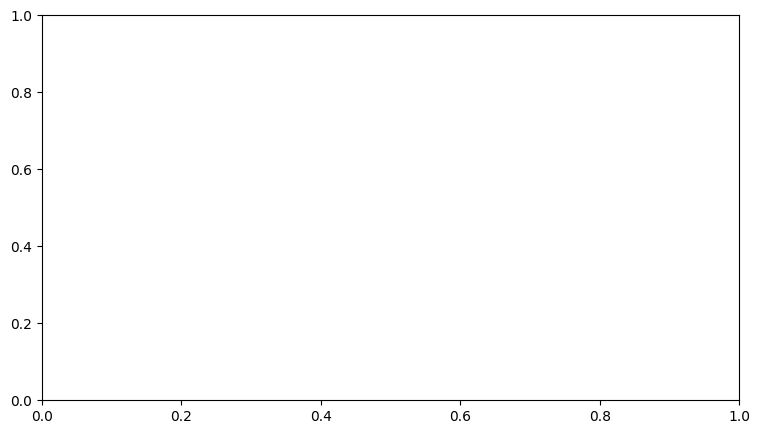

In [15]:
fig, ax = plt.subplots(figsize=(9, 5))

system_model.plot_rul(
    ax=ax,
    eol_time=time_full[-1],
    y_max= 50,
    title=f"System RUL – unit {test_unit}",
)

plt.show()

## Save video